In [82]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dense, Dropout, BatchNormalization, Input, concatenate, Flatten
from keras.models import Model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras import layers,regularizers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from keras.regularizers import l2

In [83]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

2.12.1
Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [84]:
# Read the csv files
df = pd.read_csv('TrainingShift.csv')
df_roster = pd.read_csv('TrainingStartAndFinish.csv')
df_weather = pd.read_csv('TrainingWeather.csv')

df_weather = df_weather.drop(['Date'], axis=1)

In [85]:
# Unite all dataframes
data = pd.concat([df, df_roster, df_weather], axis=1, join='inner')
data.drop(['Unpaid Break Length (minutes)', 'Location', 'Team', 'Shift Tag', 'Leave Type'],axis=1, inplace=True)

In [86]:
data['is_late'] = (pd.to_datetime(data['Start Time']) > pd.to_datetime(data['Rostered Start'])).astype(int)
data.head()

/tmp/ipykernel_22443/518060301.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['is_late'] = (pd.to_datetime(data['Start Time']) > pd.to_datetime(data['Rostered Start'])).astype(int)
/tmp/ipykernel_22443/518060301.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['is_late'] = (pd.to_datetime(data['Start Time']) > pd.to_datetime(data['Rostered Start'])).astype(int)


,Employee ID,Date,Start Time,Finish Time,Rostered Start,Rostered Finish,Weather,is_late
0,3089573,07/05/2023,08:01,16:30,08:00,16:30,Clear sky,1
1,3089573,08/05/2023,08:00,16:30,08:00,16:30,Clear sky,0
2,3089573,09/05/2023,08:00,16:32,08:00,16:30,Clear sky,0
3,3089573,10/05/2023,08:10,16:30,08:00,16:30,Mainly clear,1
4,3089573,11/05/2023,08:00,16:40,08:00,16:30,Clear sky,0


In [87]:
# Extract hour and minute from the time columns
for col in ['Start Time', 'Finish Time', 'Rostered Start', 'Rostered Finish']:
    data[col + '_hour'] = pd.to_datetime(data[col]).dt.hour
    data[col + '_minute'] = pd.to_datetime(data[col]).dt.minute

/tmp/ipykernel_22443/54638881.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col + '_hour'] = pd.to_datetime(data[col]).dt.hour
/tmp/ipykernel_22443/54638881.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col + '_minute'] = pd.to_datetime(data[col]).dt.minute
/tmp/ipykernel_22443/54638881.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col + '_hour'] = pd.to_datetime(data[col]).dt.hour
/tmp/ipykernel_22443/54638881.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsin

In [88]:
data.head()

,Employee ID,Date,Start Time,Finish Time,Rostered Start,Rostered Finish,Weather,is_late,Start Time_hour,Start Time_minute,Finish Time_hour,Finish Time_minute,Rostered Start_hour,Rostered Start_minute,Rostered Finish_hour,Rostered Finish_minute
0,3089573,07/05/2023,08:01,16:30,08:00,16:30,Clear sky,1,8,1,16,30,8,0,16,30
1,3089573,08/05/2023,08:00,16:30,08:00,16:30,Clear sky,0,8,0,16,30,8,0,16,30
2,3089573,09/05/2023,08:00,16:32,08:00,16:30,Clear sky,0,8,0,16,32,8,0,16,30
3,3089573,10/05/2023,08:10,16:30,08:00,16:30,Mainly clear,1,8,10,16,30,8,0,16,30
4,3089573,11/05/2023,08:00,16:40,08:00,16:30,Clear sky,0,8,0,16,40,8,0,16,30


In [89]:
data['Delay'] = (pd.to_datetime(data['Start Time']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60
data['Planned_Shift_Duration'] = (pd.to_datetime(data['Rostered Finish']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60

/tmp/ipykernel_22443/643706765.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Delay'] = (pd.to_datetime(data['Start Time']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60
/tmp/ipykernel_22443/643706765.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Delay'] = (pd.to_datetime(data['Start Time']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60
/tmp/ipykernel_22443/643706765.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Planned_Shift_Duration'] = (pd.to_datetime(data['Rostered Finish']) - pd.to_datetime(data

In [90]:
data.head()

,Employee ID,Date,Start Time,Finish Time,Rostered Start,Rostered Finish,Weather,is_late,Start Time_hour,Start Time_minute,Finish Time_hour,Finish Time_minute,Rostered Start_hour,Rostered Start_minute,Rostered Finish_hour,Rostered Finish_minute,Delay,Planned_Shift_Duration
0,3089573,07/05/2023,08:01,16:30,08:00,16:30,Clear sky,1,8,1,16,30,8,0,16,30,1.0,510.0
1,3089573,08/05/2023,08:00,16:30,08:00,16:30,Clear sky,0,8,0,16,30,8,0,16,30,0.0,510.0
2,3089573,09/05/2023,08:00,16:32,08:00,16:30,Clear sky,0,8,0,16,32,8,0,16,30,0.0,510.0
3,3089573,10/05/2023,08:10,16:30,08:00,16:30,Mainly clear,1,8,10,16,30,8,0,16,30,10.0,510.0
4,3089573,11/05/2023,08:00,16:40,08:00,16:30,Clear sky,0,8,0,16,40,8,0,16,30,0.0,510.0


In [91]:
data['Day_of_Week'] = pd.to_datetime(data['Date'],format='%d/%m/%Y').dt.dayofweek
data['Is_Weekend'] = data['Day_of_Week'].apply(lambda x: 1 if x >= 5 else 0)

In [92]:
data.head()

,Employee ID,Date,Start Time,Finish Time,Rostered Start,Rostered Finish,Weather,is_late,Start Time_hour,Start Time_minute,Finish Time_hour,Finish Time_minute,Rostered Start_hour,Rostered Start_minute,Rostered Finish_hour,Rostered Finish_minute,Delay,Planned_Shift_Duration,Day_of_Week,Is_Weekend
0,3089573,07/05/2023,08:01,16:30,08:00,16:30,Clear sky,1,8,1,16,30,8,0,16,30,1.0,510.0,6,1
1,3089573,08/05/2023,08:00,16:30,08:00,16:30,Clear sky,0,8,0,16,30,8,0,16,30,0.0,510.0,0,0
2,3089573,09/05/2023,08:00,16:32,08:00,16:30,Clear sky,0,8,0,16,32,8,0,16,30,0.0,510.0,1,0
3,3089573,10/05/2023,08:10,16:30,08:00,16:30,Mainly clear,1,8,10,16,30,8,0,16,30,10.0,510.0,2,0
4,3089573,11/05/2023,08:00,16:40,08:00,16:30,Clear sky,0,8,0,16,40,8,0,16,30,0.0,510.0,3,0


In [93]:
data['Month'] = pd.to_datetime(data['Date'],format='%d/%m/%Y').dt.month

In [94]:
data['Previous_Finish'] = data.groupby('Employee ID')['Finish Time'].shift(1)
data['Time_Since_Last_Shift'] = (pd.to_datetime(data['Rostered Start']) - pd.to_datetime(data['Previous_Finish'])).dt.total_seconds() / 3600

/tmp/ipykernel_22443/2279299326.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time_Since_Last_Shift'] = (pd.to_datetime(data['Rostered Start']) - pd.to_datetime(data['Previous_Finish'])).dt.total_seconds() / 3600
/tmp/ipykernel_22443/2279299326.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time_Since_Last_Shift'] = (pd.to_datetime(data['Rostered Start']) - pd.to_datetime(data['Previous_Finish'])).dt.total_seconds() / 3600


In [95]:
data['Shift_Duration'] = (pd.to_datetime(data['Finish Time']) - pd.to_datetime(data['Start Time'])).dt.total_seconds() / 60
data['Last_Shift_Duration'] = data.groupby('Employee ID')['Shift_Duration'].shift(1)

data.drop(['Shift_Duration'], axis=1, inplace=True)

/tmp/ipykernel_22443/3016118976.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Shift_Duration'] = (pd.to_datetime(data['Finish Time']) - pd.to_datetime(data['Start Time'])).dt.total_seconds() / 60
/tmp/ipykernel_22443/3016118976.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Shift_Duration'] = (pd.to_datetime(data['Finish Time']) - pd.to_datetime(data['Start Time'])).dt.total_seconds() / 60


In [96]:
# Calculate rostered shift duration
data['Rostered_Shift_Duration'] = (pd.to_datetime(data['Rostered Finish']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60

# Calculate actual shift duration
data['Actual_Shift_Duration'] = (pd.to_datetime(data['Finish Time']) - pd.to_datetime(data['Start Time'])).dt.total_seconds() / 60

/tmp/ipykernel_22443/970381174.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Rostered_Shift_Duration'] = (pd.to_datetime(data['Rostered Finish']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60
/tmp/ipykernel_22443/970381174.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Rostered_Shift_Duration'] = (pd.to_datetime(data['Rostered Finish']) - pd.to_datetime(data['Rostered Start'])).dt.total_seconds() / 60
/tmp/ipykernel_22443/970381174.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Actual_Shift_Duration'] = (pd.to_datetime(d

In [97]:
data['Overtime'] = data['Actual_Shift_Duration'] - data['Rostered_Shift_Duration']
data['Overtime'] = data['Overtime'].apply(lambda x: x if x > 0 else 0)

In [98]:
data['Yesterday_Overtime'] = data.groupby('Employee ID')['Overtime'].shift(1)
data['Had_Overtime_Yesterday'] = data['Yesterday_Overtime'].apply(lambda x: 1 if x > 0 else 0)

In [99]:
columns_to_drop = [
    'Date', 
    'Start Time', 
    'Finish Time', 
    'Rostered Start', 
    'Rostered Finish', 
    'Previous_Finish',
    'Actual_Shift_Duration', 
    'Rostered_Shift_Duration', 
    'Overtime',
]

data.drop(columns_to_drop, axis=1, inplace=True)

In [100]:
api_hash = {
    0: "Clear sky",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    61: "Slight rain",
    63: "Moderate rain",
    65: "Heavy rain",
    81: "Moderate rain showers",
    95: "Slight or moderate thunderstorm"
}

data['Weather'] = data['Weather'].map({v: k for k, v in api_hash.items()})

In [101]:
data = data.dropna()
data = data.drop(["Start Time_hour","Start Time_minute","Finish Time_hour","Finish Time_minute","Delay", ],axis=1)
data = data.drop(['Last_Shift_Duration',"Time_Since_Last_Shift" ,'Yesterday_Overtime', 'Had_Overtime_Yesterday'],axis=1)
data.head()

,Employee ID,Weather,is_late,Rostered Start_hour,Rostered Start_minute,Rostered Finish_hour,Rostered Finish_minute,Planned_Shift_Duration,Day_of_Week,Is_Weekend,Month
1,3089573,0,0,8,0,16,30,510.0,0,0,5
2,3089573,0,0,8,0,16,30,510.0,1,0,5
3,3089573,1,1,8,0,16,30,510.0,2,0,5
4,3089573,0,0,8,0,16,30,510.0,3,0,5
5,3089573,2,0,8,0,16,30,510.0,4,0,5


In [102]:
data.shape

(49980, 11)

In [103]:
unique_ids =data['Employee ID'].unique()
test_ids = np.random.choice(unique_ids, size=5, replace=False)

data_train = data[~data['Employee ID'].isin(test_ids)]
data_test = data[df['Employee ID'].isin(test_ids)]

/tmp/ipykernel_22443/3817906636.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_test = data[df['Employee ID'].isin(test_ids)]


In [104]:
# Split the data into features (X) and target (y)
x_train = data_train.drop(['is_late',"Employee ID"], axis=1)
y_train = data_train['is_late']

x_test = data_test.drop(['is_late',"Employee ID"], axis=1)
y_test = data_test['is_late']

In [105]:
x_train.head()

,Weather,Rostered Start_hour,Rostered Start_minute,Rostered Finish_hour,Rostered Finish_minute,Planned_Shift_Duration,Day_of_Week,Is_Weekend,Month
101,0,8,30,16,0,450.0,0,0,5
102,0,8,30,16,0,450.0,1,0,5
103,1,8,30,16,0,450.0,2,0,5
104,0,8,30,16,0,450.0,3,0,5
105,2,8,30,16,0,450.0,4,0,5


In [151]:
from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Embedding, Flatten, concatenate, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.optimizers import Adam

numeric_features = ['Rostered Start_hour', 'Rostered Start_minute', 'Rostered Finish_hour', 'Rostered Finish_minute', 'Planned_Shift_Duration', 'Day_of_Week', 'Is_Weekend', 'Month']
scaler = StandardScaler()
x_train[numeric_features] = scaler.fit_transform(x_train[numeric_features])
x_test[numeric_features] = scaler.transform(x_test[numeric_features])

# Define the inputs
weather_input = Input(shape=(1,), name='weather_input')
numeric_input = Input(shape=(len(numeric_features),), name='numeric_input')

# Embedding layer for weather
weather_embedding = Embedding(input_dim=100, output_dim=5)(weather_input)  # Setting input_dim to 100
weather_flat = Flatten()(weather_embedding)

# Concatenate all inputs
concatenated = concatenate([weather_flat, numeric_input])

# Build the dense layers
output = Dense(256, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))(concatenated)
output = Dropout(0.2)(output)
output = BatchNormalization()(output)
output = Dense(128, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))(output)
output = BatchNormalization()(output)
output = Dense(64, activation='relu')(output)
output = Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4),bias_regularizer=regularizers.L1L2(l1=1e-4, l2=1e-4))(output)

# Create the model
model = Model(inputs=[weather_input, numeric_input], outputs=output)

# Compile the model
optimizer = Adam(learning_rate=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(
    {
        'weather_input': x_train['Weather'],
        'numeric_input': x_train[numeric_features]
    },
    y_train,
    epochs=100,
    batch_size=5000,
    validation_data=(
        {
            'weather_input': x_test['Weather'],
            'numeric_input': x_test[numeric_features]
        }, 
        y_test
    )
)

Epoch 1/100
8/8 [==============================] - 1s 64ms/step - loss: 1.0334 - accuracy: 0.5008 - val_loss: 0.9421 - val_accuracy: 0.5000
Epoch 2/100
8/8 [==============================] - 0s 23ms/step - loss: 1.0265 - accuracy: 0.5057 - val_loss: 0.9431 - val_accuracy: 0.4896
Epoch 3/100
8/8 [==============================] - 0s 23ms/step - loss: 1.0207 - accuracy: 0.5076 - val_loss: 0.9445 - val_accuracy: 0.4760
Epoch 4/100
8/8 [==============================] - 0s 22ms/step - loss: 1.0148 - accuracy: 0.5087 - val_loss: 0.9462 - val_accuracy: 0.4719
Epoch 5/100
8/8 [==============================] - 0s 22ms/step - loss: 1.0045 - accuracy: 0.5195 - val_loss: 0.9479 - val_accuracy: 0.4663
Epoch 6/100
8/8 [==============================] - 0s 24ms/step - loss: 1.0002 - accuracy: 0.5226 - val_loss: 0.9496 - val_accuracy: 0.4511
Epoch 7/100
8/8 [==============================] - 0s 22ms/step - loss: 0.9947 - accuracy: 0.5263 - val_loss: 0.9511 - val_accuracy: 0.4495
Epoch 8/100
8/8 [===

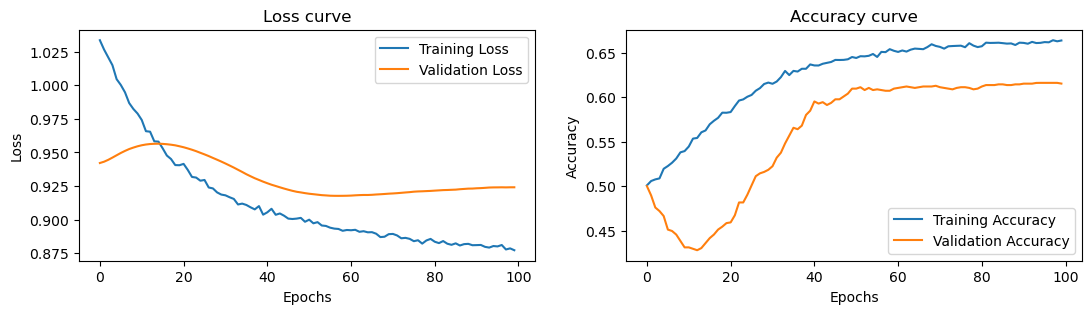

In [152]:
fig = plt.figure(figsize=[20, 3])
ax = fig.add_subplot(1, 3, 1)
ax.plot(history.history['loss'], label="Training Loss")
ax.plot(history.history['val_loss'], label="Validation Loss")
ax.set_title("Loss curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
ax.legend()
    
ax = fig.add_subplot(1, 3, 2)
ax.plot(history.history['accuracy'], label="Training Accuracy")
ax.plot(history.history['val_accuracy'], label="Validation Accuracy")
ax.set_title("Accuracy curve")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
ax.legend()

In [153]:
pred = model.predict({
        'weather_input': x_train['Weather'],
        'numeric_input': x_train[numeric_features]
    })


1172/1172 [==============================] - 3s 3ms/step


In [154]:
print(min(pred))
print(max(pred))
model.save("ML_model_for_late_prediction")

[0.06389704]
[0.7240208]
INFO:tensorflow:Assets written to: ML_model_for_late_prediction/assets
